# Initial attempt with working on the breast cancer dataset from kaggle

***AGENDA***
> 1) Complete Logistic Regression.<br>
> 2) Plot random forrest.<br>



In [77]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn import tree
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

In [3]:
# Call data
filename = 'breast-cancer-data.csv'
cwd = os.getcwd()
path = cwd+'/'+filename
bcdf = pd.read_csv(path)

### View raw dataframe

In [4]:
print(bcdf.head())
print(bcdf.shape)
print(list(bcdf))

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

      ...       texture_worst  perimeter_worst  area_worst  sm

> ***_Data is divided into mean, standard error (SE) and worst_***

### Clean dataframe and view moments
> column 0 and column 33 are not part of analysis

In [6]:
bc_df = bcdf.iloc[:,1:32] 
count_bc_df = bc_df.groupby('diagnosis').count()
moments_bc_df = bc_df.groupby(['diagnosis']).describe()

print(list(bc_df)) # can see list of columne names
print('-'*10)
print('Shape of Dataframe:', bc_df.shape) # can verify that the shape has changed due to dropped columns
print('-'*10)
print(count_bc_df) # check to see if any missing values in data frame. 
print('-'*10)
print(moments_bc_df)


#grouped_data.describe()
#grouped_data.describe()[['mean','std']]

['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
----------
Shape of Dataframe: (569, 31)
----------
           radius_mean  texture_mean  perimeter_mean  area_mean  \
diagnosis                                                         
B                  357           357             357        357   
M                  212           212             212        212   

           smoothness_mean  compactness_mean  concavity_mean  \
diagnosis                                               

### Plot the predictors as a function of diagnosis
> Best practice is to plot all predictors by class to get an idea clear image of measures.

/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


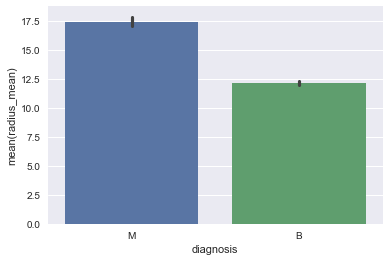

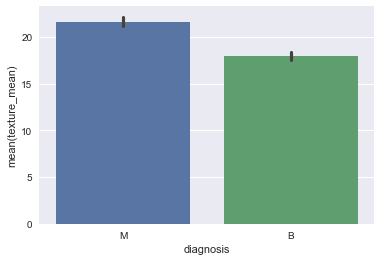

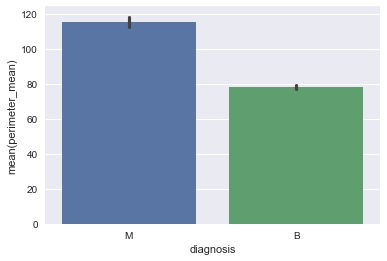

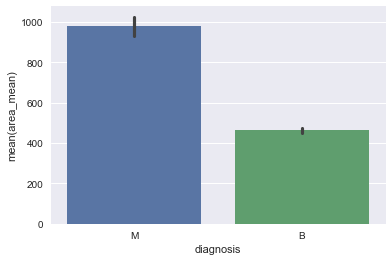

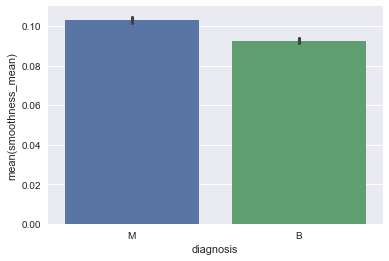

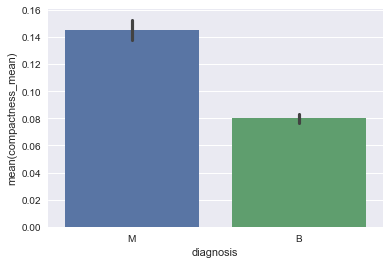

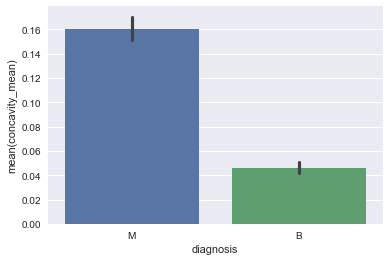

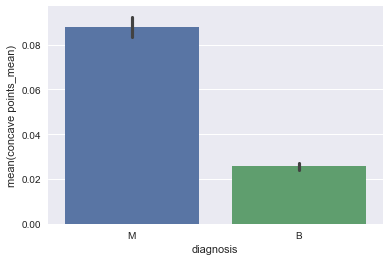

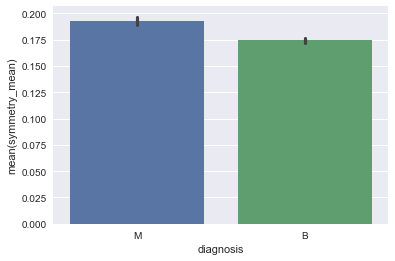

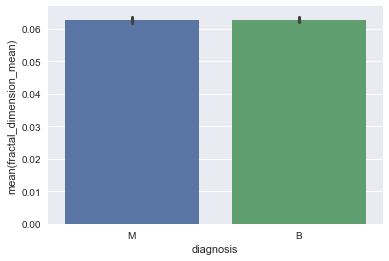

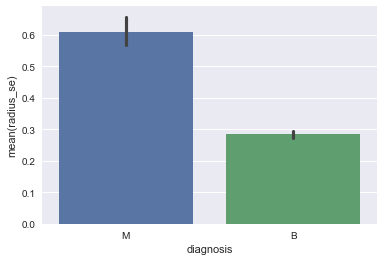

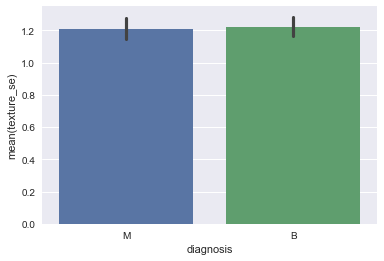

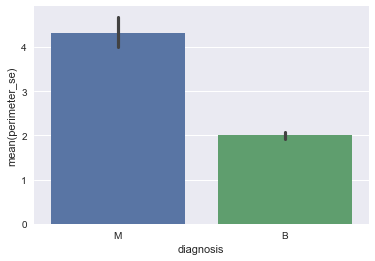

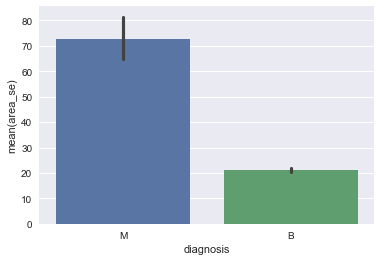

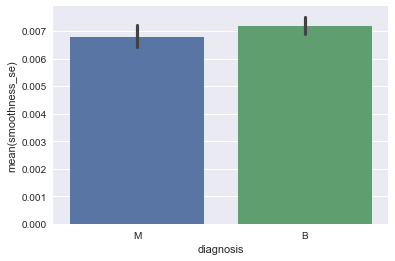

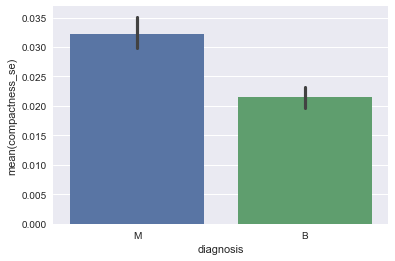

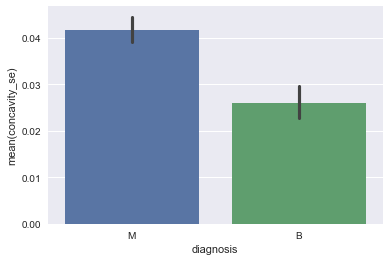

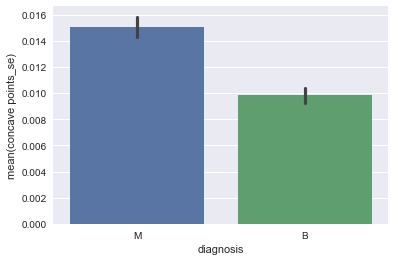

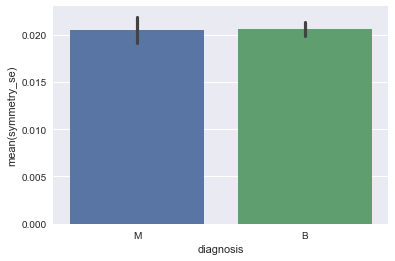

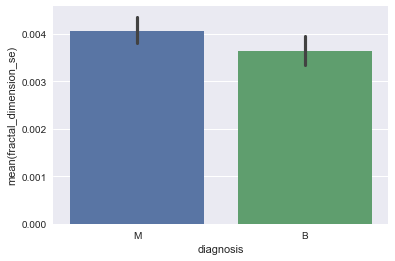

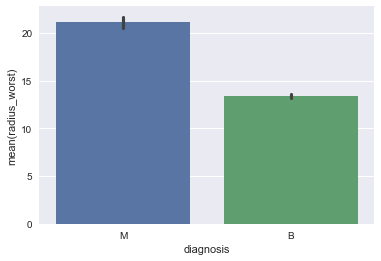

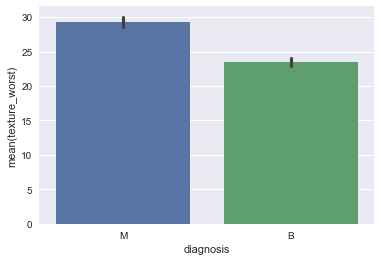

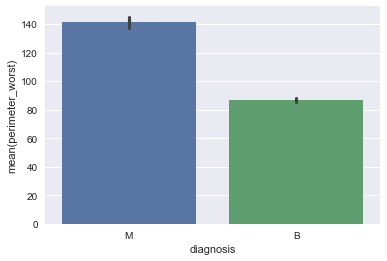

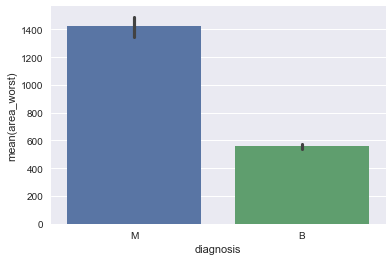

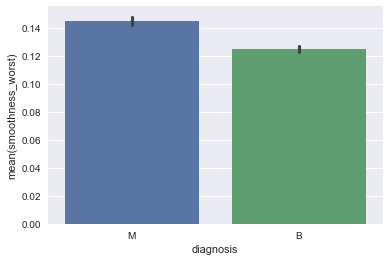

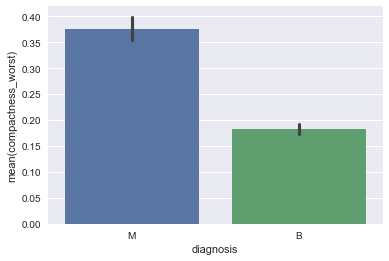

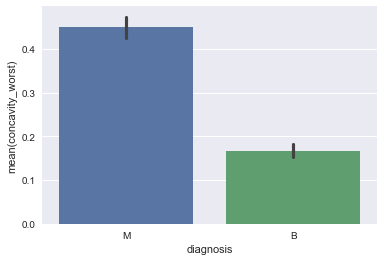

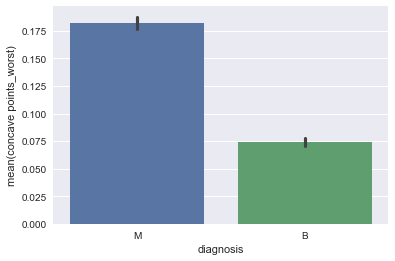

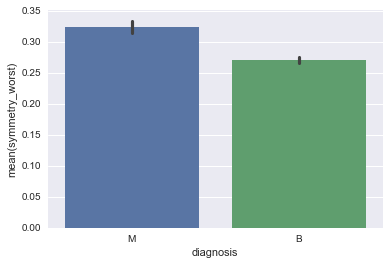

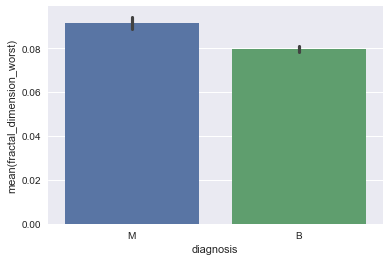

In [31]:
bc_df_plot = bc_df.select_dtypes([np.int, np.float])

for i, col in enumerate(bc_df_plot.columns):
    plt.figure(i)
    y = col
    sns.barplot(x = "diagnosis", y = y, hue = "diagnosis", data = bc_df)

### Find any covariates for data reduction

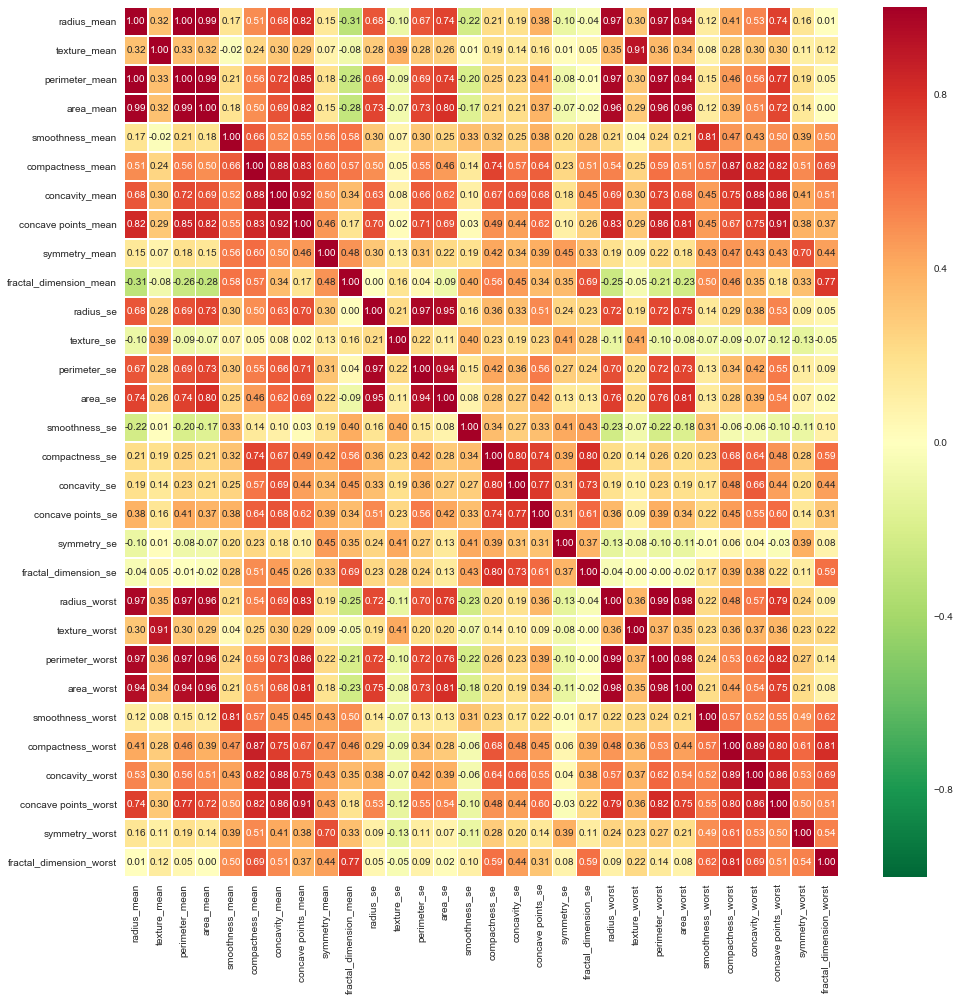

In [32]:
corr_bc = bc_df.iloc[:,1:31].corr()
plt.figure(figsize=(16,16))
corrplot = sns.heatmap(corr_bc, cmap='RdYlGn_r', linewidths = 0.5, annot = True, fmt = '.2f')

In [33]:
col_names = corr_bc.columns.values
high_corr = 0.80

for col, row in (corr_bc.abs() > high_corr).iteritems():
    print(col,':', col_names[row.values])
    print('-'*10)

# creates a dataframe of the covariates for predictors.
#d = pd.DataFrame()
#for col, row in (corr_bc.abs() > high_corr).iteritems():
#    temp = pd.DataFrame({'Predictor': col, 'Covariate': col_names[row.values]})
#    d = pd.concat([d, temp], axis = 1)

radius_mean : ['radius_mean' 'perimeter_mean' 'area_mean' 'concave points_mean'
 'radius_worst' 'perimeter_worst' 'area_worst']
----------
texture_mean : ['texture_mean' 'texture_worst']
----------
perimeter_mean : ['radius_mean' 'perimeter_mean' 'area_mean' 'concave points_mean'
 'radius_worst' 'perimeter_worst' 'area_worst']
----------
area_mean : ['radius_mean' 'perimeter_mean' 'area_mean' 'concave points_mean' 'area_se'
 'radius_worst' 'perimeter_worst' 'area_worst']
----------
smoothness_mean : ['smoothness_mean' 'smoothness_worst']
----------
compactness_mean : ['compactness_mean' 'concavity_mean' 'concave points_mean'
 'compactness_worst' 'concavity_worst' 'concave points_worst']
----------
concavity_mean : ['compactness_mean' 'concavity_mean' 'concave points_mean'
 'concavity_worst' 'concave points_worst']
----------
concave points_mean : ['radius_mean' 'perimeter_mean' 'area_mean' 'compactness_mean'
 'concavity_mean' 'concave points_mean' 'radius_worst' 'perimeter_worst'
 'are

***Looking at the list of covariates with r > 0.80 we can reduce the data set down to 14 predictors***

In [34]:
bc_df_predict = bc_df[['diagnosis','radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concave points_se', 'symmetry_se', 'symmetry_worst', 'fractal_dimension_worst']]
print(bc_df_predict.head())

  diagnosis  radius_mean  texture_mean  smoothness_mean  compactness_mean  \
0         M        17.99         10.38          0.11840           0.27760   
1         M        20.57         17.77          0.08474           0.07864   
2         M        19.69         21.25          0.10960           0.15990   
3         M        11.42         20.38          0.14250           0.28390   
4         M        20.29         14.34          0.10030           0.13280   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  \
0         0.2419                 0.07871     1.0950      0.9053   
1         0.1812                 0.05667     0.5435      0.7339   
2         0.2069                 0.05999     0.7456      0.7869   
3         0.2597                 0.09744     0.4956      1.1560   
4         0.1809                 0.05883     0.7572      0.7813   

   smoothness_se  compactness_se  concave points_se  symmetry_se  \
0       0.006399         0.04904            0.01587      0.03003  

### Create training and test set data (Three options).
1) Single training/test set.<br>
2) KFold validation option - cross validation method. <br>
3) KFold validation option with stratification - cross validation method (best practice).<br>
   
   >***_note:_*** The diagnosis variable is categorical. Must change it to a numerical<br>
   > M = 0<br>
   > B = 1<br>

In [45]:
#convert the diagnosis vairable to numeric for machine learning. 
bc_df_predict['diagnosis'] = pd.get_dummies(bc_df_predict['diagnosis'])
bc_df_predict_var = bc_df[['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concave points_se', 'symmetry_se', 'symmetry_worst', 'fractal_dimension_worst']]

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [56]:
# Option 1: Single training/test split.
#train_set, test_set = train_test_split(bc_df_predict, test_size = 0.20, train_size = 0.80)
#print('train_set size:', train_set.shape)
#print('test_set size:', test_set.shape)
#print('train_set %:', np.divide(train_set.shape[0], (train_set.shape[0]+test_set.shape[0])))

#Create X, Y Variables
#X_train = train_set.iloc[:,1:]
#Y_train = train_set.diagnosis
#X_test = test_set.iloc[:,1:]
#Y_test = test_set.diagnosis

# Option 2: KFold (5 folds) training/test splits.
#kf = KFold(round((len(bc_df_predict))*0.80), n_folds = 5, shuffle = False) # want training set to be 90% of total # of observations. 

# view the contents of each training and testing set. 
#print ('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
#for k, data in enumerate (kf, start = 1):
#    print ('{:^9} {} {:^25}'.format(k, data[0], data[1]))

# Option 3: KFold (10 folds) training with stratification (default in cross_val_score)
knn = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn, bc_df_predict_var, bc_df_predict['diagnosis'], cv = 10, scoring = 'accuracy') #cv splots into 10 folds cross val; scoring = 'accuracy' for classfication accuracy
print (scores)
print('-'*10)
print(scores.mean())



[ 0.82758621  0.82758621  0.87719298  0.84210526  0.92982456  0.92982456
  0.92982456  0.875       0.92857143  0.91071429]
----------
0.88782300579


### Model Selection

#### K-Nearest Neighbors Classifier
> 1) Hypertuning K.
> 2) Bias-Variance trade off plot.
> 3) KNN on optimal K parameter.

In [131]:
# try out k=2 through k=25 and record testing accuracy 
k_range = range(2,51)
k_scores = []
k_error = []
for k in k_range:
    model_knn = KNeighborsClassifier(n_neighbors = k)
    scores_knn = cross_val_score(model_knn, bc_df_predict_var, bc_df_predict['diagnosis'], cv = 10, scoring = 'accuracy')
    k_scores.append(scores_knn.mean())
    k_error.append(scores_knn.std())

k = list(range(2,51))
k = pd.DataFrame(k, columns = ['k-value'])
k_scores = pd.DataFrame(k_scores, columns = ['Cross Validation k-accuracy'])
k_error = pd.DataFrame(k_error, columns = ['Standard Deviation'])
k_val_acc = pd.concat([k, k_scores, k_error], axis = 1)
print(k_val_acc)
print('-'*10)

u, t, z = k_val_acc.loc[k_val_acc['Cross Validation k-accuracy'].idxmax()]
u = u.astype(int)

val_k_scores = []
# perform knn on largest accuracy of k-value (k = u)
val_model_knn = KNeighborsClassifier(n_neighbors = u)
val_scores_knn = cross_val_score(val_model_knn, bc_df_predict_var, bc_df_predict['diagnosis'], cv = 10, scoring = 'accuracy')
val_k_scores.append(val_scores_knn)
mean_val_k_scores = val_scores_knn.mean()

print('Model Accuracy (k=%d): ' % (u), mean_val_k_scores)

    k-value  Cross Validation k-accuracy  Standard Deviation
0         2                     0.845154            0.054454
1         3                     0.882497            0.038310
2         4                     0.877202            0.045043
3         5                     0.887823            0.041354
4         6                     0.877109            0.039386
5         7                     0.884346            0.040578
6         8                     0.880651            0.029335
7         9                     0.878958            0.034479
8        10                     0.884191            0.033540
9        11                     0.887855            0.036568
10       12                     0.877203            0.035784
11       13                     0.878988            0.035211
12       14                     0.878896            0.031903
13       15                     0.884283            0.034915
14       16                     0.884221            0.033343
15       17             

#### Bias-Variance Trade-off
> selected the k = 29 for KNN model.

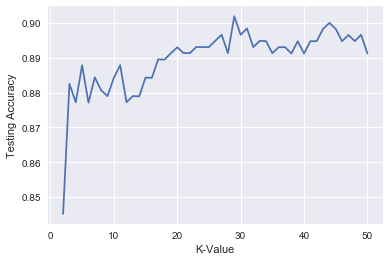

In [139]:
plt.plot(k, k_scores)
#plt.errorbar(k_val_acc[0], k_val_acc[1], yerr = k_val_acc[2], fmt='-o')
plt.xlabel('K-Value')
plt.ylabel('Testing Accuracy')

In [127]:
# computational efficient of method for tuning hyperparameters
from sklearn.grid_search import GridSearchCV

k_range = list(range(2, 51))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors = k_range, weights = weight_options) #create a dict with a list of k values.
grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'accuracy')
grid.fit(bc_df_predict_var, bc_df_predict['diagnosis'])
gridscores = grid.grid_scores_ # 49 named tuples

In [128]:
# dig deeper into best model
print(grid.best_score_)
print('-'*10)
print('best parameters based on input:', grid.best_params_)
print('-'*10)
print('model parameters:', grid.best_estimator_)

0.9015817223198594
----------
n_neighbours: {'n_neighbors': 29, 'weights': 'uniform'}
----------
model parameters: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=29, p=2,
           weights='uniform')


#### Let's predict with our best parameters (k = 29, weights = uniform)

In [141]:
#Create a training and test split to test out prediction
train_set, test_set = train_test_split(bc_df_predict, test_size = 0.20, train_size = 0.80)

#Create X, Y Variables
X_train = train_set.iloc[:,1:]
Y_train = train_set.diagnosis
X_test = test_set.iloc[:,1:]
Y_test = test_set.diagnosis

# Train model with all of data (best practice - avoiding that to use existing data for prediction)
model_knn = KNeighborsClassifier(n_neighbors = 29, weights = 'uniform')
fit_knn = model_knn.fit(X_train, Y_train) # you'll lose potentially valuable data that model can learn from. 
prediction_knn = fit_knn.predict(X_test)


acc_knn = metrics.accuracy_score(prediction_knn,Y_test)
print('Model Accuracy: ', acc_knn)

Model Accuracy:  0.885964912281


#### We can get an idea of which observations the model is having a hard time predicting

In [142]:
prediction_knn = pd.DataFrame(prediction_knn, columns=['Predicted Outcome'])
probab_knn = fit_knn.predict_proba(X_test)
probab_knn = pd.DataFrame(probab_knn, columns=['Prob. M', 'Prob. B'])
preds_knn = pd.concat([prediction_knn, probab_knn], axis = 1)
print(preds_knn.head())

   Predicted Outcome   Prob. M   Prob. B
0                  1  0.000000  1.000000
1                  1  0.068966  0.931034
2                  0  1.000000  0.000000
3                  1  0.068966  0.931034
4                  1  0.068966  0.931034


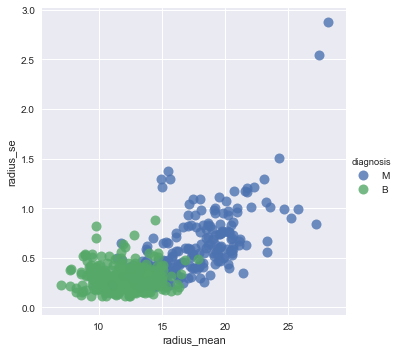

In [183]:
sns.lmplot('radius_mean', 'radius_se', data = bc_df, fit_reg = False, hue = "diagnosis", scatter_kws = {"marker": "D","s": 100})

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  app.launch_new_instance()


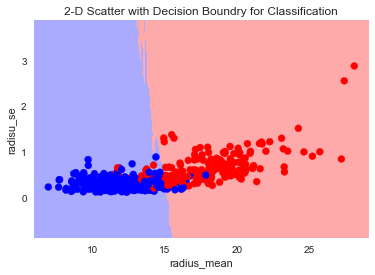

In [189]:
from sklearn import neighbors

X = bc_df_predict[['radius_mean', 'radius_se']]
X = pd.DataFrame.as_matrix(X)
y = bc_df_predict[['diagnosis']]
y = pd.DataFrame.as_matrix(y)

h = .02  # step size in the mesh
 
# Create color maps
cmap_light = ListedColormap(['#FFAAAA','#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000','#00FF00', '#0000FF'])
 
# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors = 29, weights = 'uniform')
clf.fit(X, y)
 
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
 
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
 
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('radius_mean')
plt.ylabel('radisu_se')
plt.title('2-D Scatter with Decision Boundry for Classification')


#### Logistic Regression

In [78]:
#Initial run of the logistic regression classifier with cross validation.
logreg_scores = []
model_logreg = LogisticRegression()
scores_logreg = cross_val_score(model_logreg, bc_df_predict_var, bc_df_predict['diagnosis'], cv = 10, scoring = 'accuracy')
logreg_scores.append(scores_logreg.mean())
print(logreg_scores)

[0.91072724915737613]


Initial attempt rendered 91% accuracy.<br>

However due to the predictors having different scales and potentially different units (though not specified in data set), we should ***scale*** the data. <br>
> see http://bit.ly/2ifhW92 for details on scaling vs standardizing variables for regression.

In [96]:
# Scaling predictors
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
stan_pred_var = sc.fit(bc_df_predict).transform(bc_df_predict) # note this function standardizes each observation by removing bias (subtracting by mean) and standardizing to unit variance (dividing by standard deviation) of the column

#### Random Forrest classifier

In [144]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn import tree

model_rf = RandomForestClassifier(bootstrap = True, criterion = 'entropy', n_estimators = 100)
fit_rf = model_rf.fit(X_train,Y_train)
prediction_rf = fit_rf.predict(X_test)


acc_rf = metrics.accuracy_score(prediction_rf,Y_test)
print('Model Accuracy: ', acc_rf)

Model Accuracy:  0.947368421053


***Let's dig deeper into model with probabilities of prediciton***

In [145]:
prediction_rf = pd.DataFrame(prediction_rf, columns=['Predicted Outcome'])
probab_rf = fit_rf.predict_proba(X_test)
probab_rf = pd.DataFrame(probab_rf, columns=['Prob. M', 'Prob. B'])
preds_rf = pd.concat([prediction_rf, probab_rf], axis = 1)
print(preds_rf.head())
print('-'*50)

feat_imp_rf = list(zip(X_train, fit_rf.feature_importances_))
feat_imp_rf = pd.DataFrame(feat_imp_rf, columns=['Predictor', 'Importance Score']).sort_values(by = 'Importance Score', ascending = False)
print(feat_imp_rf)

   Predicted Outcome  Prob. M  Prob. B
0                  1     0.01     0.99
1                  1     0.17     0.83
2                  0     0.94     0.06
3                  1     0.02     0.98
4                  1     0.12     0.88
--------------------------------------------------
                  Predictor  Importance Score
0               radius_mean          0.261749
6                 radius_se          0.145810
3          compactness_mean          0.113880
1              texture_mean          0.086695
12           symmetry_worst          0.068093
10        concave points_se          0.054215
2           smoothness_mean          0.042791
5    fractal_dimension_mean          0.041436
13  fractal_dimension_worst          0.039523
11              symmetry_se          0.036955
9            compactness_se          0.033400
8             smoothness_se          0.029835
7                texture_se          0.024401
4             symmetry_mean          0.021217
